<a href="https://colab.research.google.com/github/JoshFowlkes/DS-Unit-2-Applied-Modeling/blob/master/module3/assignment_applied_modeling_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Applied Modeling, Module 3

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploration, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Share at least 1 visualization on Slack.

(If you have not yet completed an initial model yet for your portfolio project, then do today's assignment using your Tanzania Waterpumps model.)

## Stretch Goals
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction.
- [ ] If you log-transformed your regression target, then convert your PDP back to original units. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox.I Get readable category names on your plot, instead of integer category codes.

## Links
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

In [1]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly pdpbox
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module3')

     |████████████████████████████████| 92kB 3.5MB/s 
     |████████████████████████████████| 133kB 9.0MB/s 
     |████████████████████████████████| 7.1MB 37.8MB/s 
     |████████████████████████████████| 57.7MB 373kB/s 
     |████████████████████████████████| 614kB 35.8MB/s 
     |████████████████████████████████| 225kB 41.3MB/s 
     |████████████████████████████████| 768kB 32.2MB/s 
     |████████████████████████████████| 194kB 47.2MB/s 
     |████████████████████████████████| 51kB 21.4MB/s 
     |████████████████████████████████| 51kB 18.4MB/s 
     |████████████████████████████████| 737kB 45.4MB/s 
  Created wheel for pandas-profiling: filename=pandas_profiling-2.3.0-py2.py3-none-any.whl size=145036 sha256=62e45aa80a2f69bf0cd4616893877e7d9675f7cc084d65aec16416df0153b3ef
  Stored in directory: /root/.cache/pip/wheels/ce/c7/f1/dbfef4848ebb048cb1d4a22d1ed0c62d8ff2523747235e19fe
  Created wheel for pdpbox: filename=PDPbox-0.2.0-cp36-none-any.whl size=57690723 sha256=0a5a91d17b35d5ddd5

In [0]:
# Various Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas_profiling
import plotly.express as px
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox.pdp import pdp_interact, pdp_interact_plot
import plotly.graph_objs as go # 3D plotly
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier

In [3]:
# bringing in THE dataset

df = pd.read_csv('https://query.data.world/s/dh4qojydat5rryqzot3q4x3osoj6dc')
df.head()

,uniq_id,product_name,manufacturer,price,number_available_in_stock,number_of_reviews,number_of_answered_questions,average_review_rating,amazon_category_and_sub_category,customers_who_bought_this_item_also_bought,description,product_information,product_description,items_customers_buy_after_viewing_this_item,customer_questions_and_answers,customer_reviews,sellers
0,eac7efa5dbd3d667f26eb3d3ab504464,Hornby 2014 Catalogue,Hornby,£3.42,5 new,15,1.0,4.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,http://www.amazon.co.uk/Hornby-R8150-Catalogue...,Product Description Hornby 2014 Catalogue Box ...,Technical Details Item Weight640 g Product Dim...,Product Description Hornby 2014 Catalogue Box ...,http://www.amazon.co.uk/Hornby-R8150-Catalogue...,Does this catalogue detail all the previous Ho...,Worth Buying For The Pictures Alone (As Ever) ...,"{""seller""=>[{""Seller_name_1""=>""Amazon.co.uk"", ..."
1,b17540ef7e86e461d37f3ae58b7b72ac,FunkyBuys® Large Christmas Holiday Express Fes...,FunkyBuys,£16.99,NaN,2,1.0,4.5 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,http://www.amazon.co.uk/Christmas-Holiday-Expr...,Size Name:Large FunkyBuys® Large Christmas Hol...,Technical Details Manufacturer recommended age...,Size Name:Large FunkyBuys® Large Christmas Hol...,http://www.amazon.co.uk/Christmas-Holiday-Expr...,can you turn off sounds // hi no you cant turn...,Four Stars // 4.0 // 18 Dec. 2015 // By\n \...,"{""seller""=>{""Seller_name_1""=>""UHD WHOLESALE"", ..."
2,348f344247b0c1a935b1223072ef9d8a,CLASSIC TOY TRAIN SET TRACK CARRIAGES LIGHT EN...,ccf,£9.99,2 new,17,2.0,3.9 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,http://www.amazon.co.uk/Classic-Train-Lights-B...,BIG CLASSIC TOY TRAIN SET TRACK CARRIAGE LIGHT...,Technical Details Manufacturer recommended age...,BIG CLASSIC TOY TRAIN SET TRACK CARRIAGE LIGHT...,http://www.amazon.co.uk/Train-With-Tracks-Batt...,What is the gauge of the track // Hi Paul.Trut...,**Highly Recommended!** // 5.0 // 26 May 2015 ...,"{""seller""=>[{""Seller_name_1""=>""DEAL-BOX"", ""Sel..."
3,e12b92dbb8eaee78b22965d2a9bbbd9f,HORNBY Coach R4410A BR Hawksworth Corridor 3rd,Hornby,£39.99,NaN,1,2.0,5.0 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,NaN,Hornby 00 Gauge BR Hawksworth 3rd Class W 2107...,Technical Details Item Weight259 g Product Dim...,Hornby 00 Gauge BR Hawksworth 3rd Class W 2107...,NaN,NaN,I love it // 5.0 // 22 July 2013 // By\n \n...,NaN
4,e33a9adeed5f36840ccc227db4682a36,Hornby 00 Gauge 0-4-0 Gildenlow Salt Co. Steam...,Hornby,£32.19,NaN,3,2.0,4.7 out of 5 stars,Hobbies > Model Trains & Railway Sets > Rail V...,http://www.amazon.co.uk/Hornby-R6367-RailRoad-...,Product Description Hornby RailRoad 0-4-0 Gild...,Technical Details Item Weight159 g Product Dim...,Product Description Hornby RailRoad 0-4-0 Gild...,http://www.amazon.co.uk/Hornby-R2672-RailRoad-...,NaN,Birthday present // 5.0 // 14 April 2014 // By...,NaN


In [4]:
df.shape

(10000, 17)

In [5]:
df.isnull().sum(axis=0)

uniq_id                                           0
product_name                                      0
manufacturer                                      7
price                                          1435
number_available_in_stock                      2500
number_of_reviews                                18
number_of_answered_questions                    765
average_review_rating                            18
amazon_category_and_sub_category                690
customers_who_bought_this_item_also_bought     1062
description                                     651
product_information                              58
product_description                             651
items_customers_buy_after_viewing_this_item    3065
customer_questions_and_answers                 9086
customer_reviews                                 21
sellers                                        3082
dtype: int64

In [6]:
df.dtypes


uniq_id                                         object
product_name                                    object
manufacturer                                    object
price                                           object
number_available_in_stock                       object
number_of_reviews                               object
number_of_answered_questions                   float64
average_review_rating                           object
amazon_category_and_sub_category                object
customers_who_bought_this_item_also_bought      object
description                                     object
product_information                             object
product_description                             object
items_customers_buy_after_viewing_this_item     object
customer_questions_and_answers                  object
customer_reviews                                object
sellers                                         object
dtype: object

In [0]:
# Some Wrangling and Cleaning, still much more to do though

# removing the Euros symbol to later convert it to floats
df['price'] = df['price'].str[1:]

# removing the string after the number of availalble stock to convert to an interger later
df['number_available_in_stock'] = df['number_available_in_stock'].str.extract('(\d+)')
df['number_available_in_stock'] = df['number_available_in_stock'].fillna(0.0).astype(int)

# removing the unneccessary clutter around the rating so that I can later convert to float
df['average_review_rating'] = df['average_review_rating'].str.extract('(\d+(?:\.\d+)?)')

# removing the URL to the new product, will continue to clean and get it just down to the item
df['customers_who_bought_this_item_also_bought'] = df['customers_who_bought_this_item_also_bought'].str[24:]
df['items_customers_buy_after_viewing_this_item'] = df['items_customers_buy_after_viewing_this_item'].str[24:]

# rather than have category>subcategory>subsubcategory in one column, I gave each their own column
df['category'] = df['amazon_category_and_sub_category'].str.split('>').str[0].tolist()
df['sub_category'] = df['amazon_category_and_sub_category'].str.split('>').str[1].tolist()
df['sub_sub_category'] = df['amazon_category_and_sub_category'].str.split('>').str[2].tolist()
df['sub_sub_sub_category'] = df['amazon_category_and_sub_category'].str.split('>').str[3].tolist()

# fixing commas in strings in number of reviews and then converting column to floats
df['number_of_reviews'] = df['number_of_reviews'].replace('1,040','1040')
df['number_of_reviews'] = df['number_of_reviews'].replace('1,399','1399')
df['number_of_reviews'] = df['number_of_reviews'].fillna(0.0).astype(int)

# converting Average review rating to floats 
#df['average_review_rating'] = df['average_review_rating'].astype(float)

# fixing strings in price column so they can be converted to floats
df['price'] = df['price'].str.split(' - £').str[0].tolist()
df['upper_range_price'] = df['price'].str.split(' - £').str[1].tolist()
df['price'] = df['price'].replace('2,439.92', '2439.92')
df['price'] = df['price'].astype(float)

# unusable variance 
unusable_variance = ['uniq_id',
                     'amazon_category_and_sub_category',
                     
                     'customers_who_bought_this_item_also_bought', 
                     'description',
                     'product_information', 
                     'product_description', 
                     'items_customers_buy_after_viewing_this_item', 
                     'customer_questions_and_answers',
                     'customer_reviews', 
                     'sellers', 
                     'upper_range_price',]
df = df.drop(columns=unusable_variance)


# dropping some categoricals for the sake of a linear model, will reuse these at later point
unusable_categoricals = ['product_name',
                         #'manufacturer', 
                         #'category',
                        # 'sub_category', 
                        # 'sub_sub_category', 
                       #  'sub_sub_sub_category'
                        ]

df = df.drop(columns=unusable_categoricals)

#df = df[np.isfinite(df['price'])]
#df = df[np.isfinite(df['number_of_answered_questions'])]
#df = df[np.isfinite(df['average_review_rating'])]

df = df.dropna()


# Baseline


In [8]:
df['average_review_rating'].value_counts(normalize=True)

# so if you guess a 5 star review, you'll be right 47% of the time
# my interpretation of this is that, a lot of these may be recently listed products and therefore 
# have a small number of reviews, all likely due to their marketing strategy to get their
# product to rank higher in searches


5.0    0.670415
4.0    0.139273
4.5    0.048443
4.8    0.032007
4.7    0.027682
4.3    0.022491
4.6    0.019031
4.4    0.013841
4.9    0.010381
4.2    0.008651
4.1    0.006055
3.5    0.000865
3.9    0.000865
Name: average_review_rating, dtype: float64

# Fitting a Model(Logistic Regression)

In [0]:
# now making train/val/test split



train, val = train_test_split(df, train_size=.8, test_size = .2, 
                              random_state=69)


In [0]:
# Assigning X feature matrices and y target vectors

# assigning the target
target = 'average_review_rating'

X_train = train.drop(columns=target)
y_train = train[target]

X_val = val.drop(columns=target)
y_val = val[target]

# Label Encoder
label_enc = preprocessing.LabelEncoder()
#X_train_encoded = label_enc.fit_transform(X_train)


In [11]:
pipeline = make_pipeline(
        ce.OrdinalEncoder(),
        SimpleImputer(),
        StandardScaler(),
        LogisticRegression()

)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_val)
print('Validation Accuracy: ', accuracy_score(y_val, y_pred))

Validation Accuracy:  0.6594827586206896


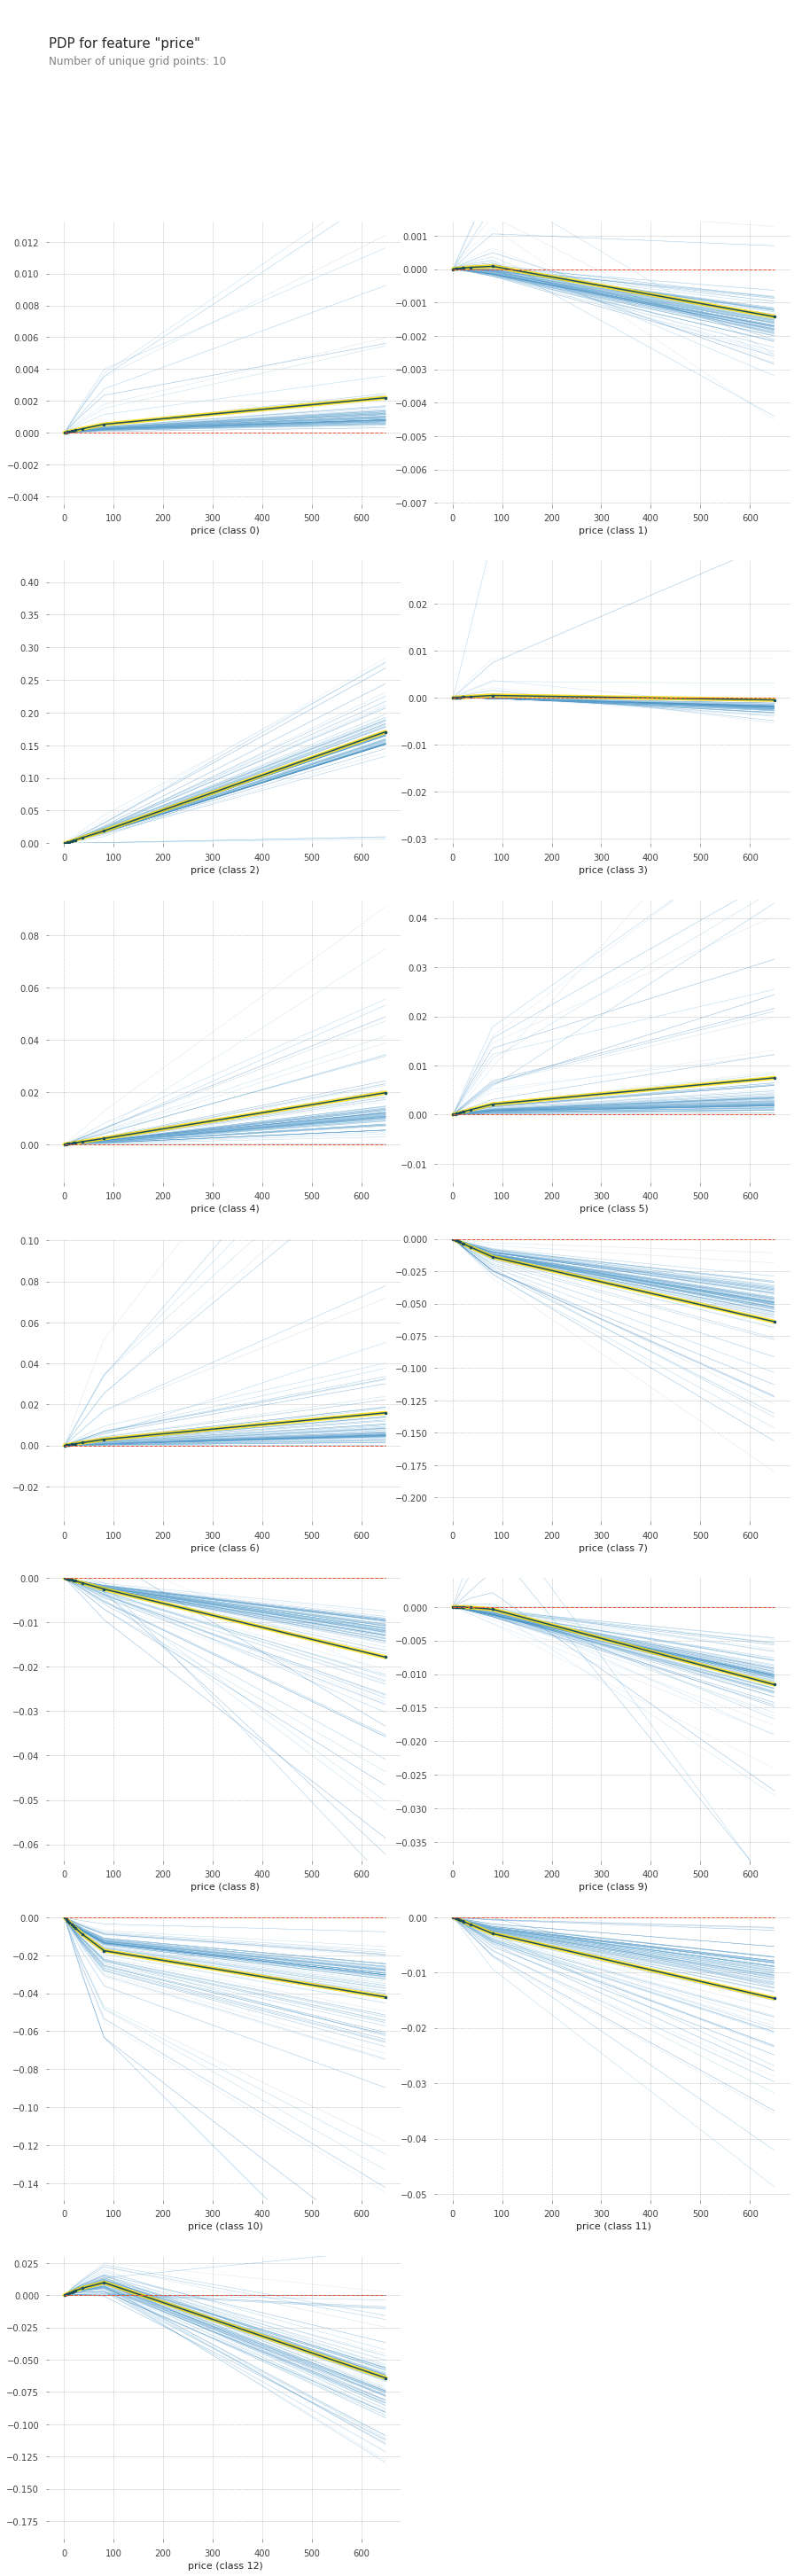

In [12]:
feature = 'price'

isolated = pdp_isolate(
    model=pipeline, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=100);

# Fitting A Model (Random Forest Classifier)

In [13]:
pipeline = make_pipeline(
        ce.OrdinalEncoder(),
        SimpleImputer(),
        StandardScaler(),
        RandomForestClassifier(random_state=69)

)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_val)
print('Validation Accuracy: ', accuracy_score(y_val, y_pred))

Validation Accuracy:  0.6163793103448276


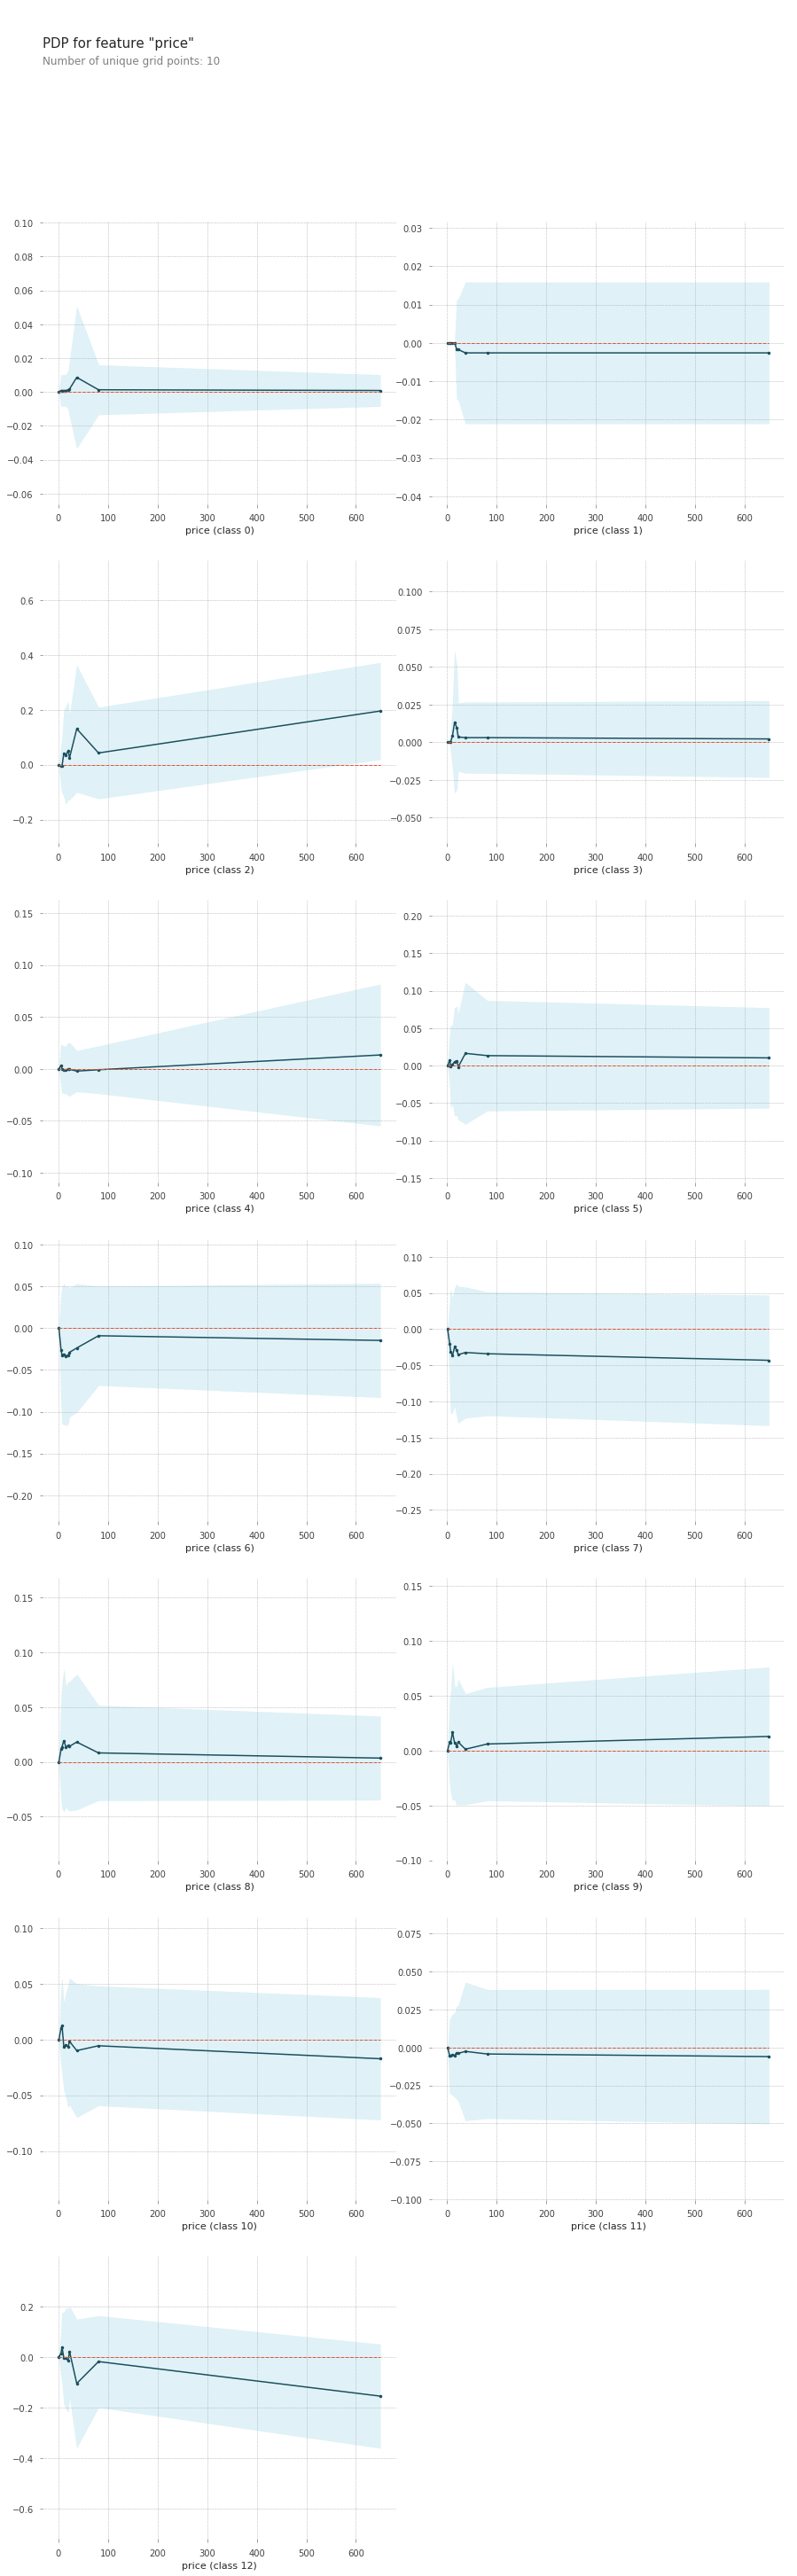

In [14]:
feature = 'price'

isolated = pdp_isolate(
    model=pipeline, 
    dataset=X_val, 
    model_features=X_val.columns, 
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

# Fitting a Model(Decision Tree Classifier)

In [19]:
pipeline = make_pipeline(
        ce.OrdinalEncoder(),
        SimpleImputer(),
        StandardScaler(),
        DecisionTreeClassifier(random_state=69)

)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_val)
print('Validation Accuracy: ', accuracy_score(y_val, y_pred))

Validation Accuracy:  0.5086206896551724


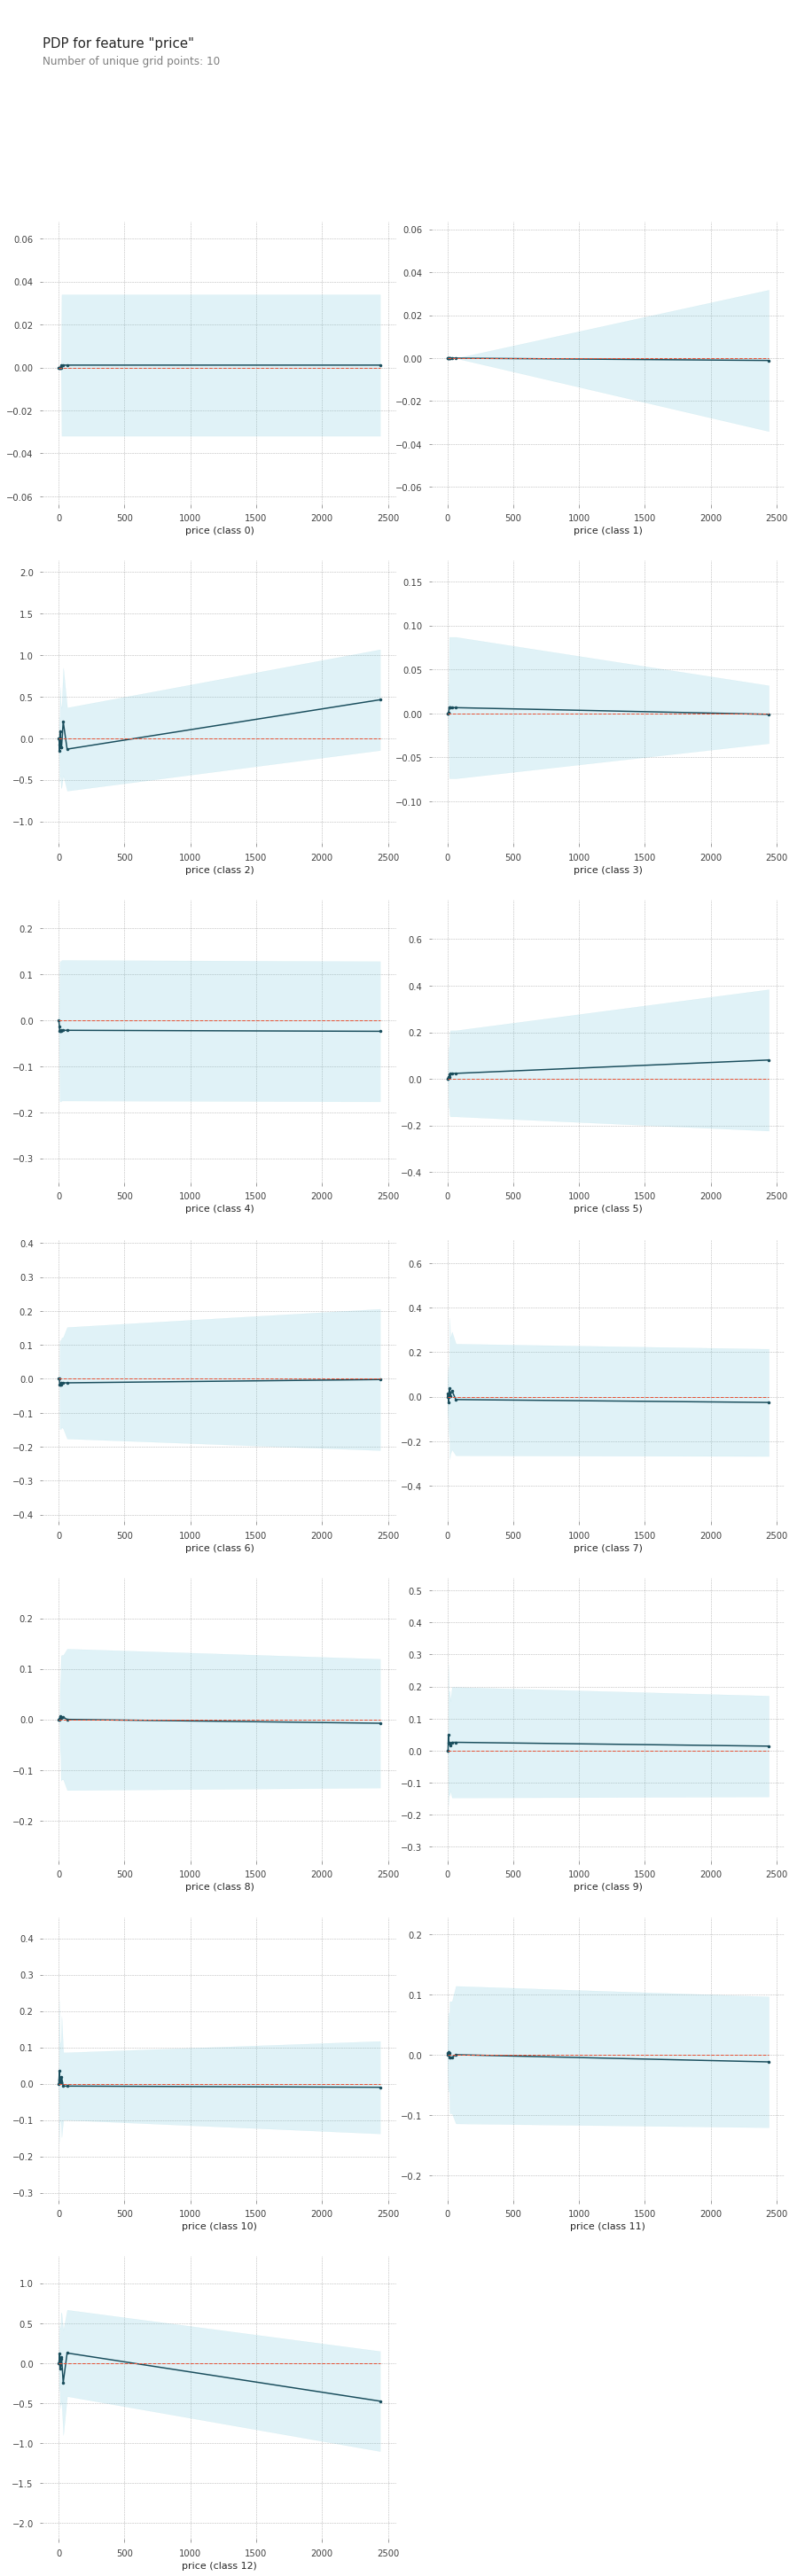

In [17]:
feature = 'price'

isolated = pdp_isolate(
    model=pipeline,
    dataset=X_train,
    model_features=X_train.columns,
    feature=feature)

pdp_plot(isolated, feature_name=feature);